In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#Edge detection
def edge_det(img):
    gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ed = cv2.Canny(gr, 50, 150)
    return ed

In [4]:
#hough accumulator
def hough_acc(ed, theta_res=1, rho_res=1):
    h, w = ed.shape
    diag_len = int(np.ceil(np.sqrt(h**2 + w**2)))
    rhos = np.arange(-diag_len, diag_len + 1, rho_res)
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))
    acc = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(ed)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            theta = thetas[t_idx]
            rho = int(round(x * np.cos(theta) + y * np.sin(theta))) + diag_len
            if 0 <= rho < len(rhos):
                acc[rho, t_idx] += 1

    return acc, thetas, rhos

In [5]:
#Peaks detection
def peaks(acc, num_peaks, thres=0.5):
    acc_copy = acc.copy()
    peak = []
    max_vote = np.max(acc)
    for _ in range(num_peaks):
        idx = np.argmax(acc_copy)
        rho_idx, theta_idx = np.unravel_index(idx, acc_copy.shape)
        if acc_copy[rho_idx, theta_idx] >= thres * max_vote:
            peak.append((rho_idx, theta_idx))
            print(f"  Peak at rho_idx={rho_idx}, theta_idx={theta_idx}, votes={acc_copy[rho_idx, theta_idx]}")
            acc_copy[max(0, rho_idx-20):min(acc_copy.shape[0], rho_idx+20),
                     max(0, theta_idx-20):min(acc_copy.shape[1], theta_idx+20)] = 0

    print(f"Total peaks found: {len(peak)}")
    return peak

In [6]:
#line detection
def dr_lines(img, peaks, thetas, rhos):
    img_copy = img.copy()
    diag_len = int(np.ceil(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))
    for rho_idx, theta_idx in peaks:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + diag_len * (-b))
        y1 = int(y0 + diag_len * (a))
        x2 = int(x0 - diag_len * (-b))
        y2 = int(y0 - diag_len * (a))
        cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return img_copy

In [7]:
#plotting images
def proc_image(image_pth, theta_res=1, rho_res=1, num_peaks=10, threshold=0.5):
    img = cv2.imread(image_pth)
    edges = edge_det(img)
    accumulator, thetas, rhos = hough_acc(edges, theta_res, rho_res)
    peak = peaks(accumulator, num_peaks, threshold)
    line_img = dr_lines(img, peak, thetas, rhos)

    # Visualizing results
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # Edge Image
    plt.subplot(2, 3, 2)
    plt.title('Edge Image')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    # Hough Accumulator Heatmap
    plt.subplot(2, 3, 3)
    plt.title('Hough Accumulator Heatmap')
    plt.imshow(accumulator, cmap='hot', aspect='auto', norm=plt.Normalize(vmin=0, vmax=np.max(accumulator)))
    plt.xlabel('Theta index')
    plt.ylabel('Rho index')
    plt.colorbar()
    # Significant Intersections (Peaks)
    plt.subplot(2, 3, 4)
    plt.title('Significant Intersections (Peaks)')
    plt.scatter([p[1] for p in peak], [p[0] for p in peak], color='red', s=50, label='Peaks')
    plt.legend()
    plt.xlabel('Theta index')
    plt.ylabel('Rho index')
    plt.gca().invert_yaxis()
    plt.grid()
    # Detected Lines
    plt.subplot(2, 3, 5)
    plt.title('Detected Lines')
    plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Processing test2.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=394, theta_idx=53, votes=121
  Peak at rho_idx=277, theta_idx=37, votes=111
  Peak at rho_idx=628, theta_idx=130, votes=98
  Peak at rho_idx=557, theta_idx=110, votes=94
  Peak at rho_idx=539, theta_idx=68, votes=83
  Peak at rho_idx=432, theta_idx=120, votes=74
Total peaks found: 6


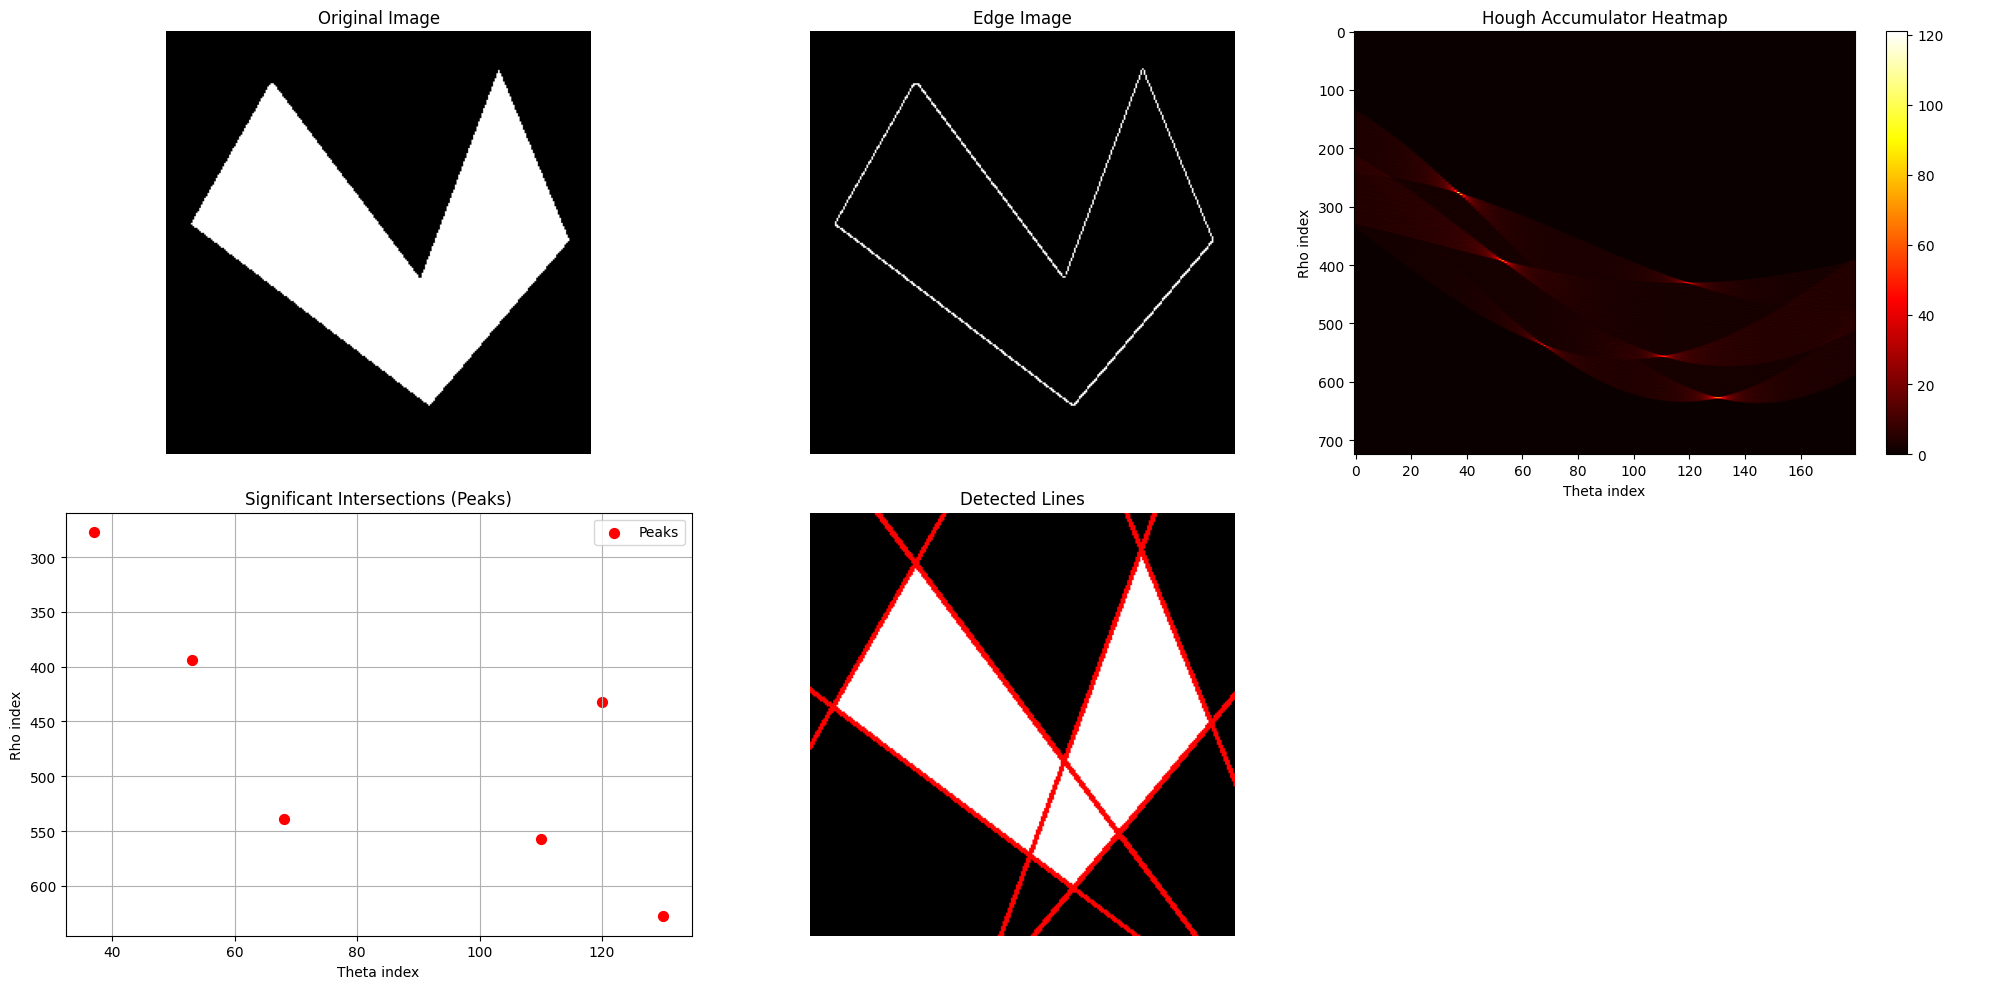


Processing test2.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=280, theta_idx=19, votes=91
Total peaks found: 1


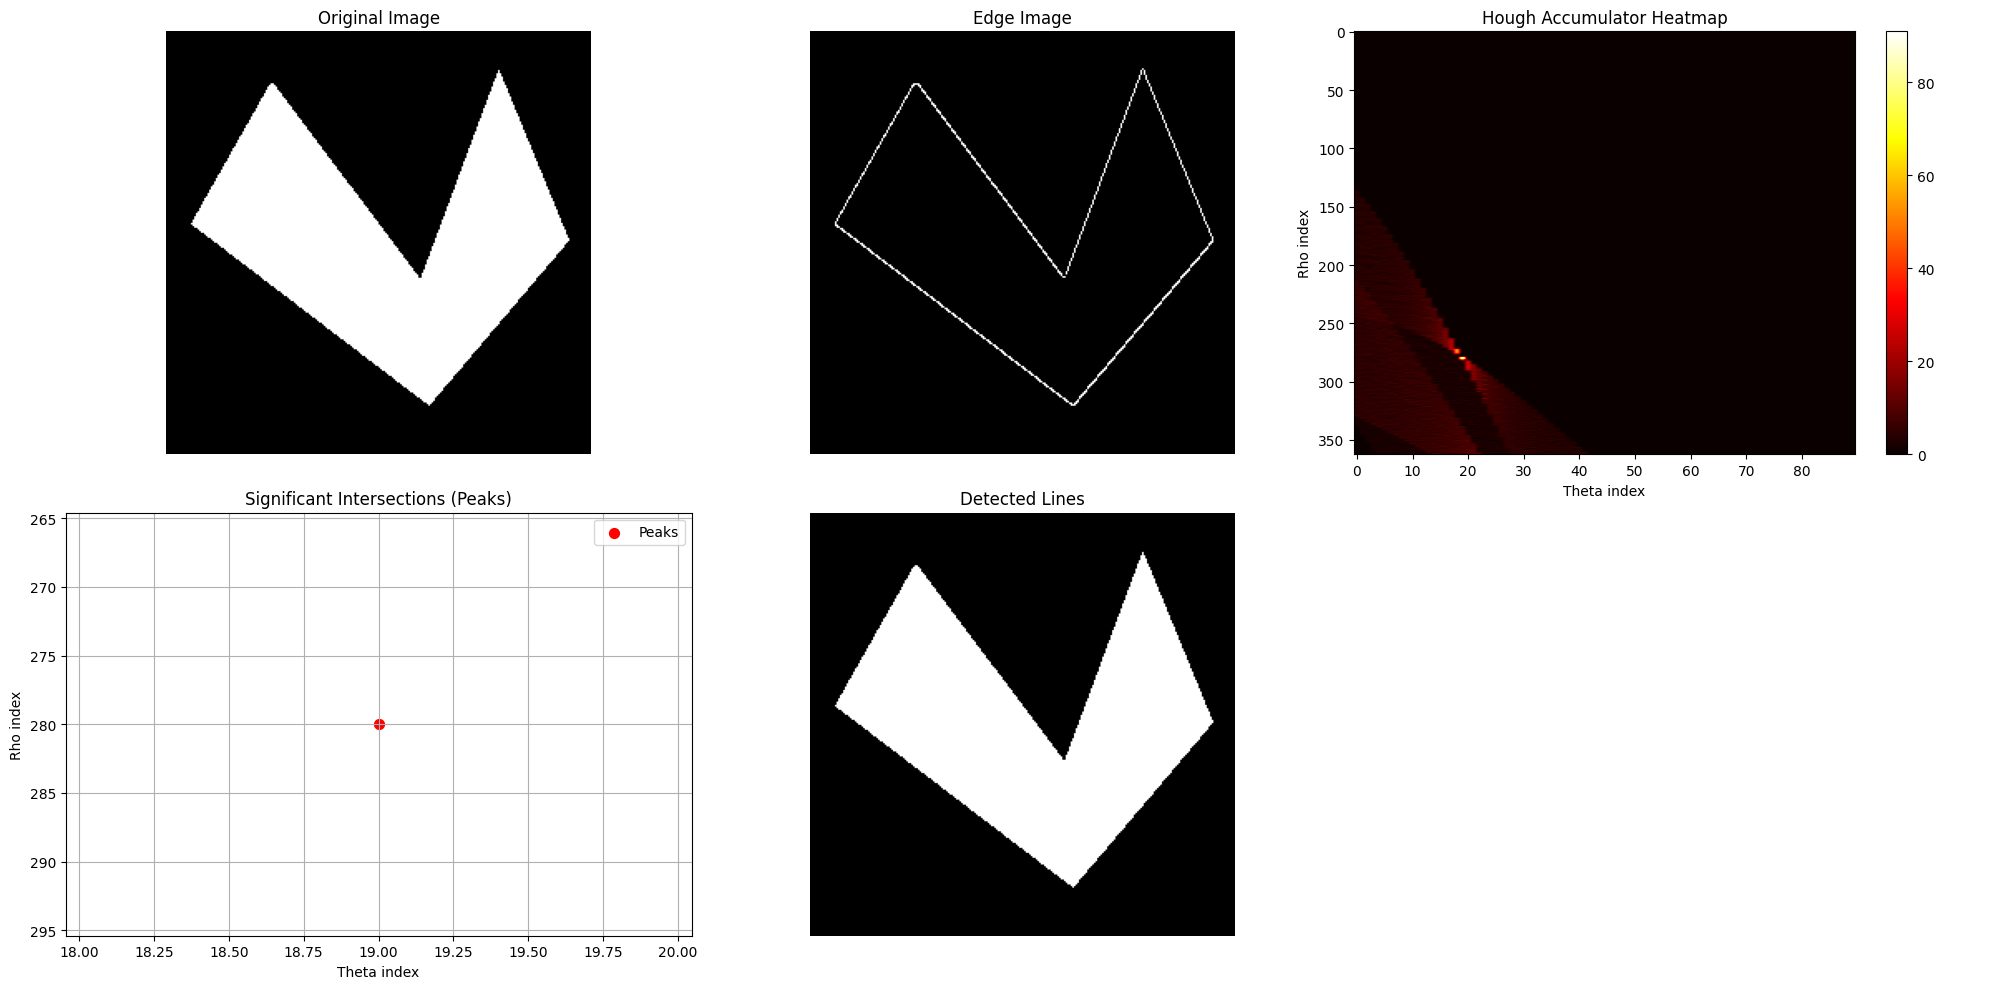


Processing test2.bmp with coarse quantization (theta_res=5, rho_res=5)
  Peak at rho_idx=138, theta_idx=0, votes=4
Total peaks found: 1


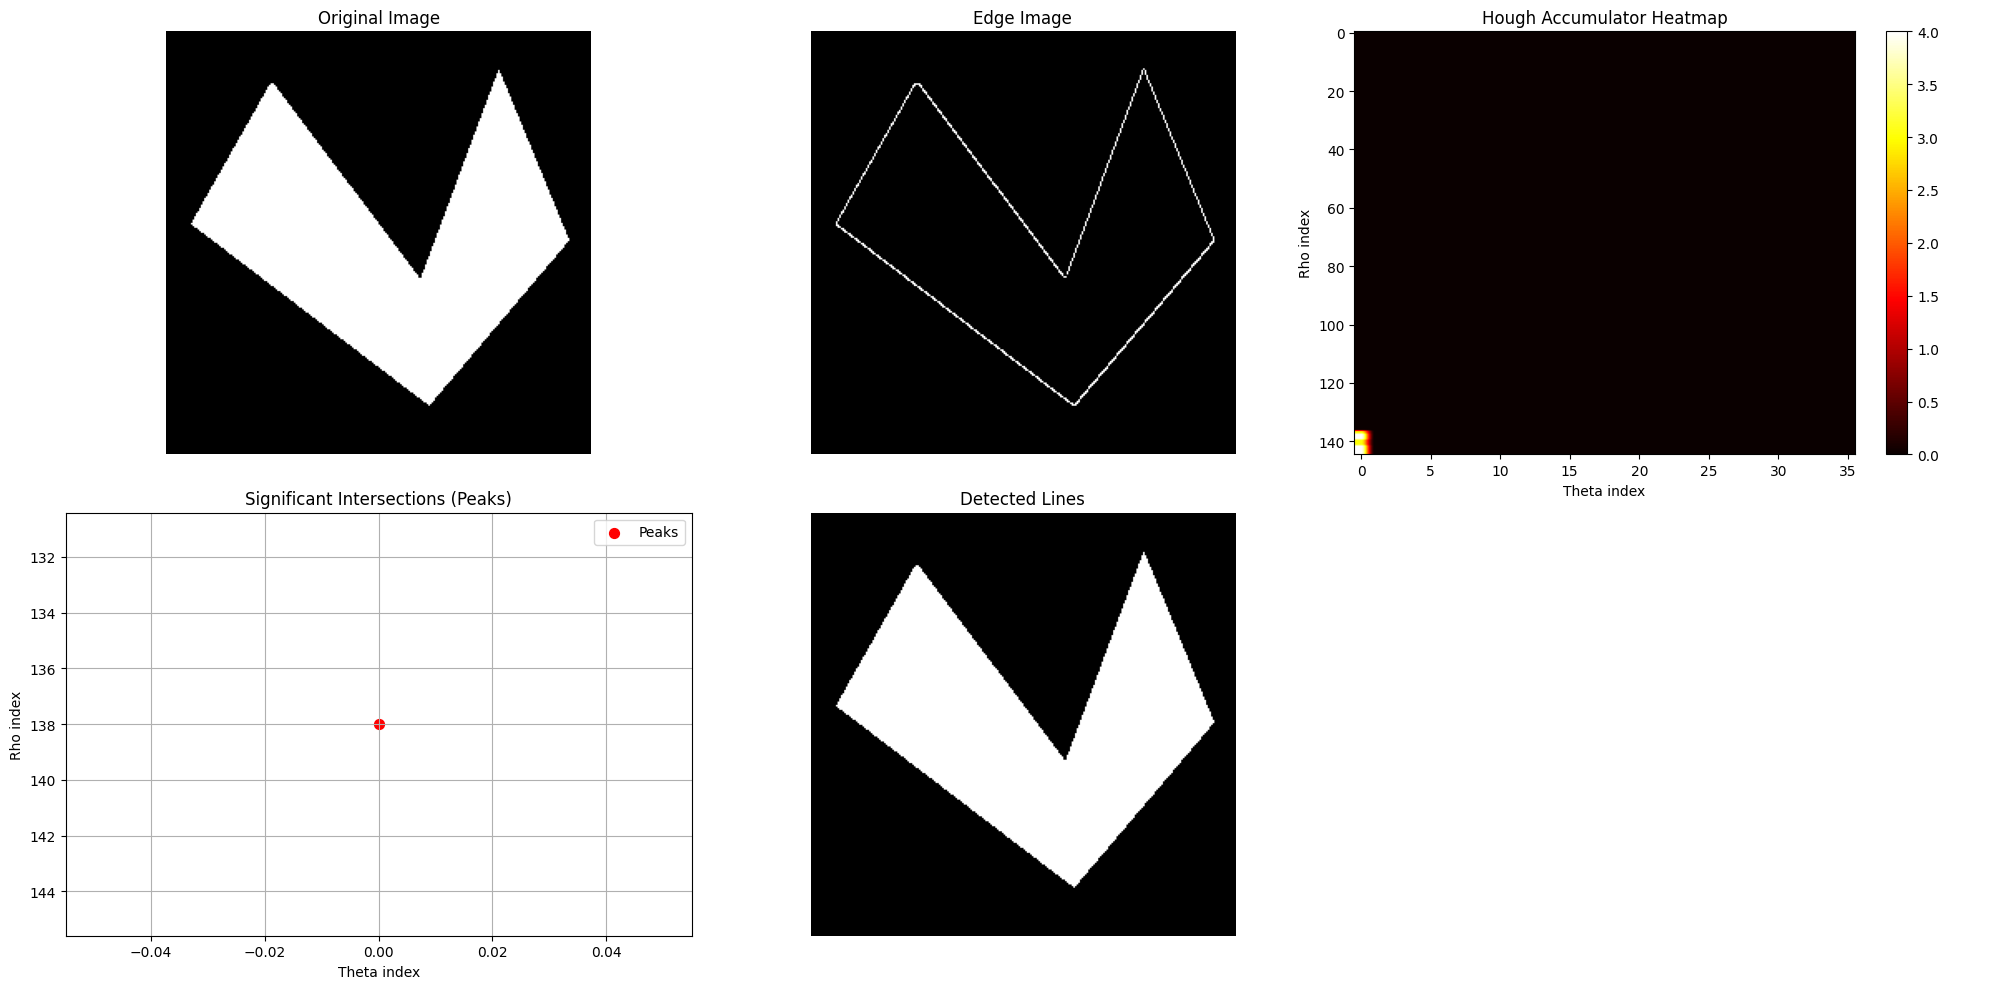


Processing input.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=251, theta_idx=11, votes=80
  Peak at rho_idx=346, theta_idx=113, votes=77
  Peak at rho_idx=467, theta_idx=107, votes=63
  Peak at rho_idx=141, theta_idx=5, votes=51
  Peak at rho_idx=167, theta_idx=21, votes=47
  Peak at rho_idx=408, theta_idx=148, votes=47
Total peaks found: 6


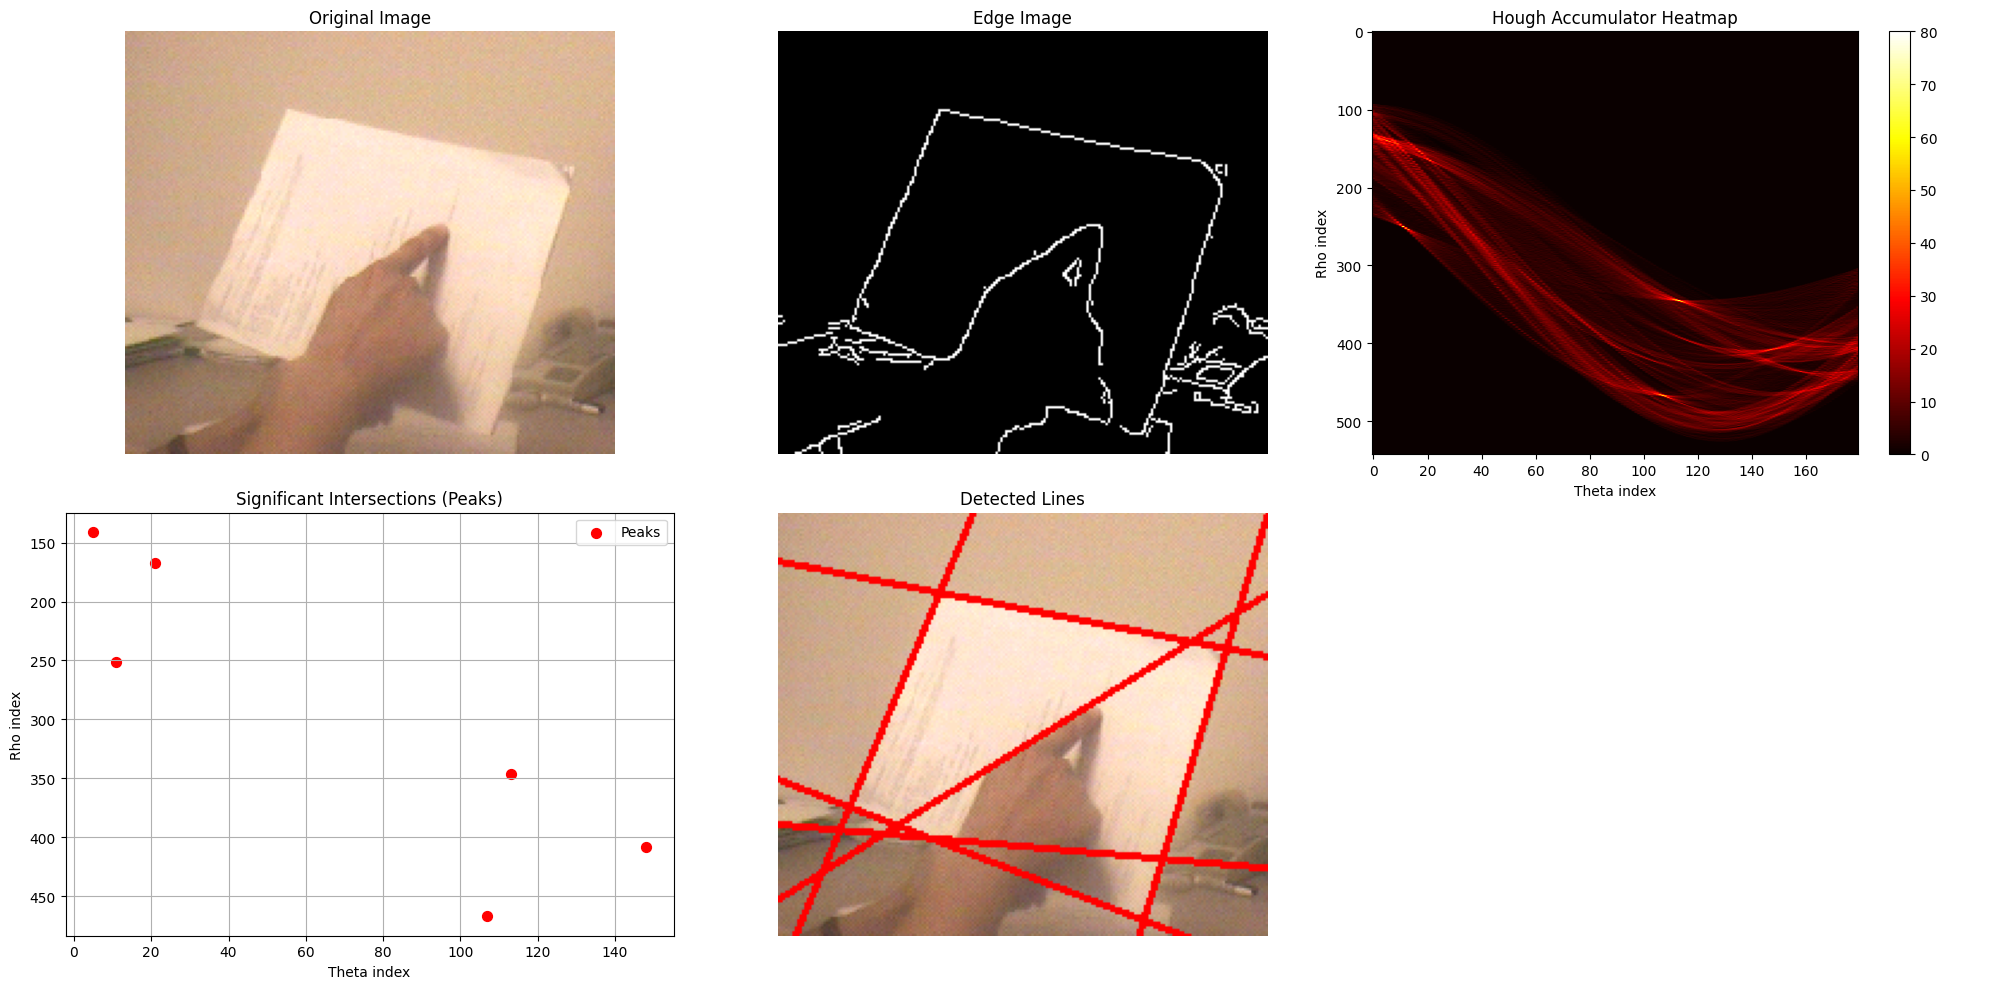


Processing input.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=253, theta_idx=6, votes=76
  Peak at rho_idx=142, theta_idx=3, votes=51
  Peak at rho_idx=165, theta_idx=10, votes=43
Total peaks found: 3


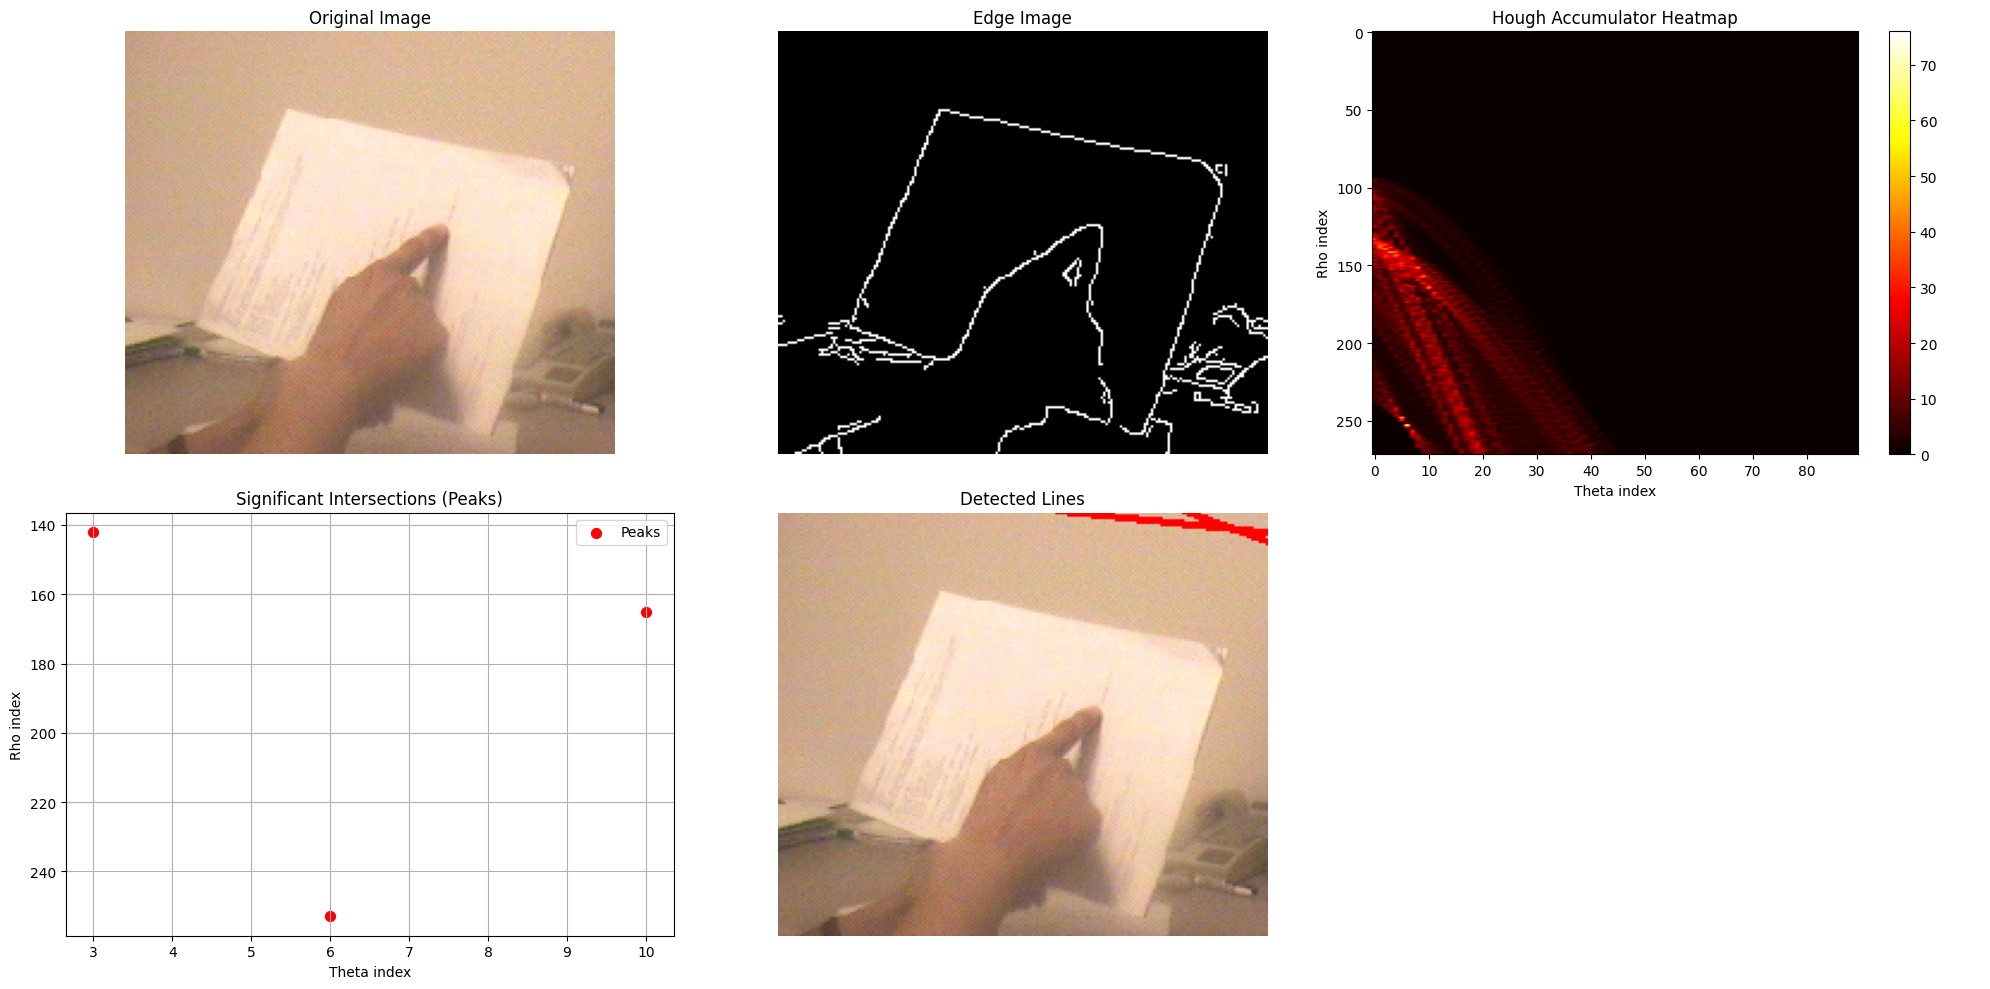


Processing input.bmp with coarse quantization (theta_res=5, rho_res=5)
  Peak at rho_idx=106, theta_idx=0, votes=18
Total peaks found: 1


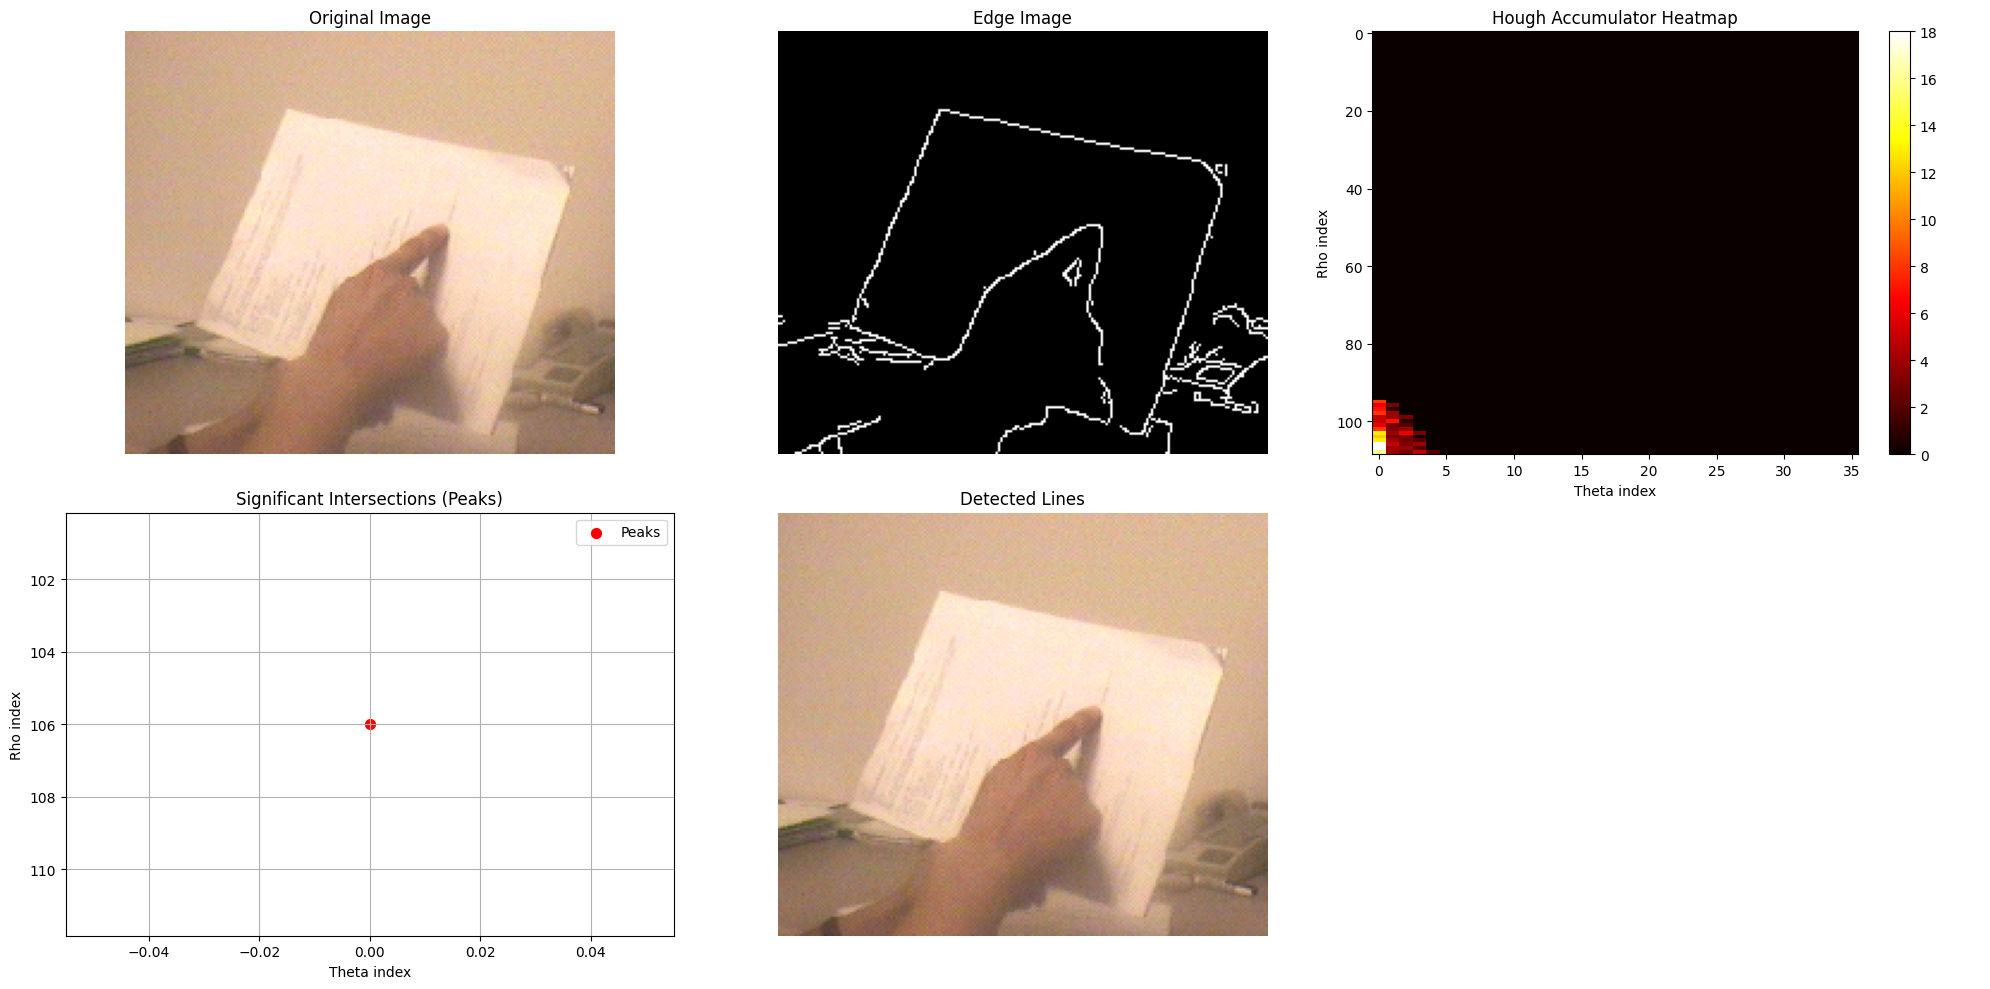


Processing test.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=434, theta_idx=51, votes=114
  Peak at rho_idx=570, theta_idx=161, votes=104
  Peak at rho_idx=408, theta_idx=93, votes=77
Total peaks found: 3


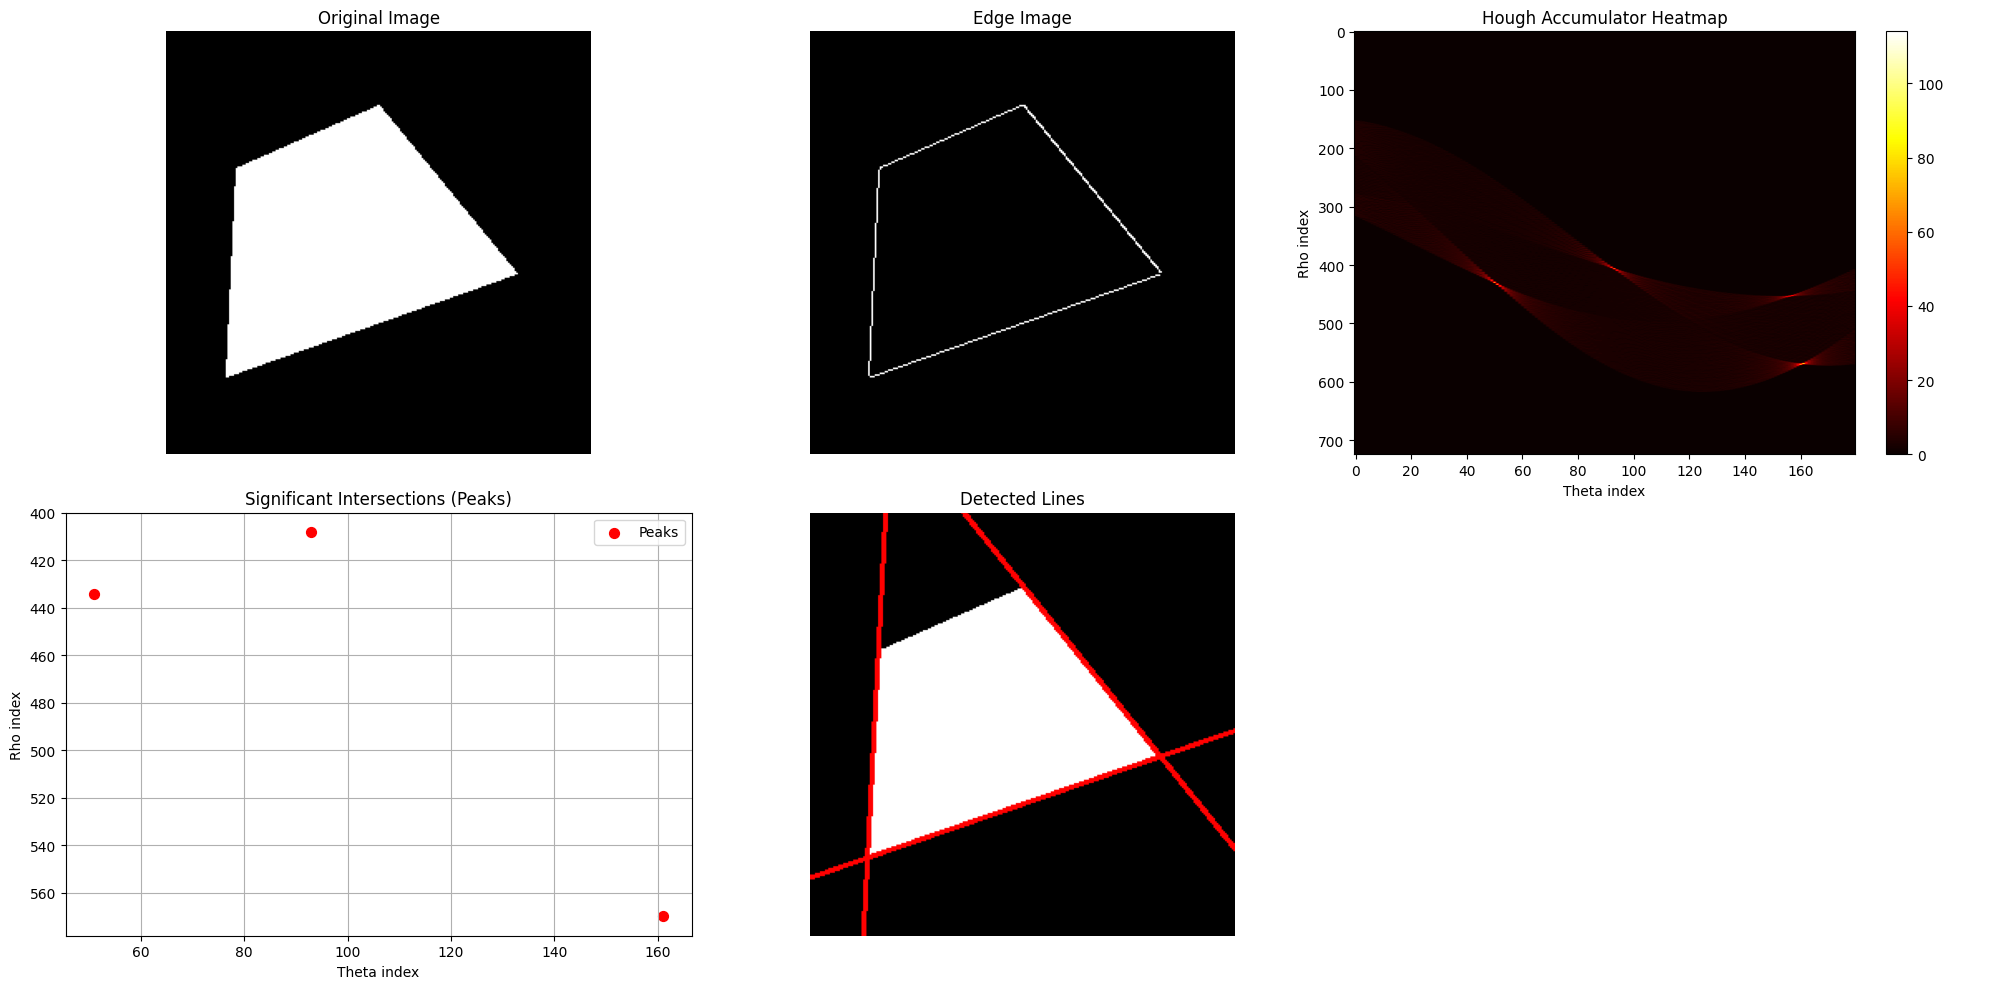


Processing test.bmp with fine quantization (theta_res=1, rho_res=1)
  Peak at rho_idx=349, theta_idx=14, votes=8
  Peak at rho_idx=308, theta_idx=6, votes=7
  Peak at rho_idx=361, theta_idx=40, votes=7
  Peak at rho_idx=197, theta_idx=11, votes=5
  Peak at rho_idx=221, theta_idx=10, votes=5
  Peak at rho_idx=248, theta_idx=10, votes=5
  Peak at rho_idx=269, theta_idx=10, votes=5
  Peak at rho_idx=322, theta_idx=34, votes=5
  Peak at rho_idx=328, theta_idx=7, votes=5
  Peak at rho_idx=155, theta_idx=0, votes=4
Total peaks found: 10


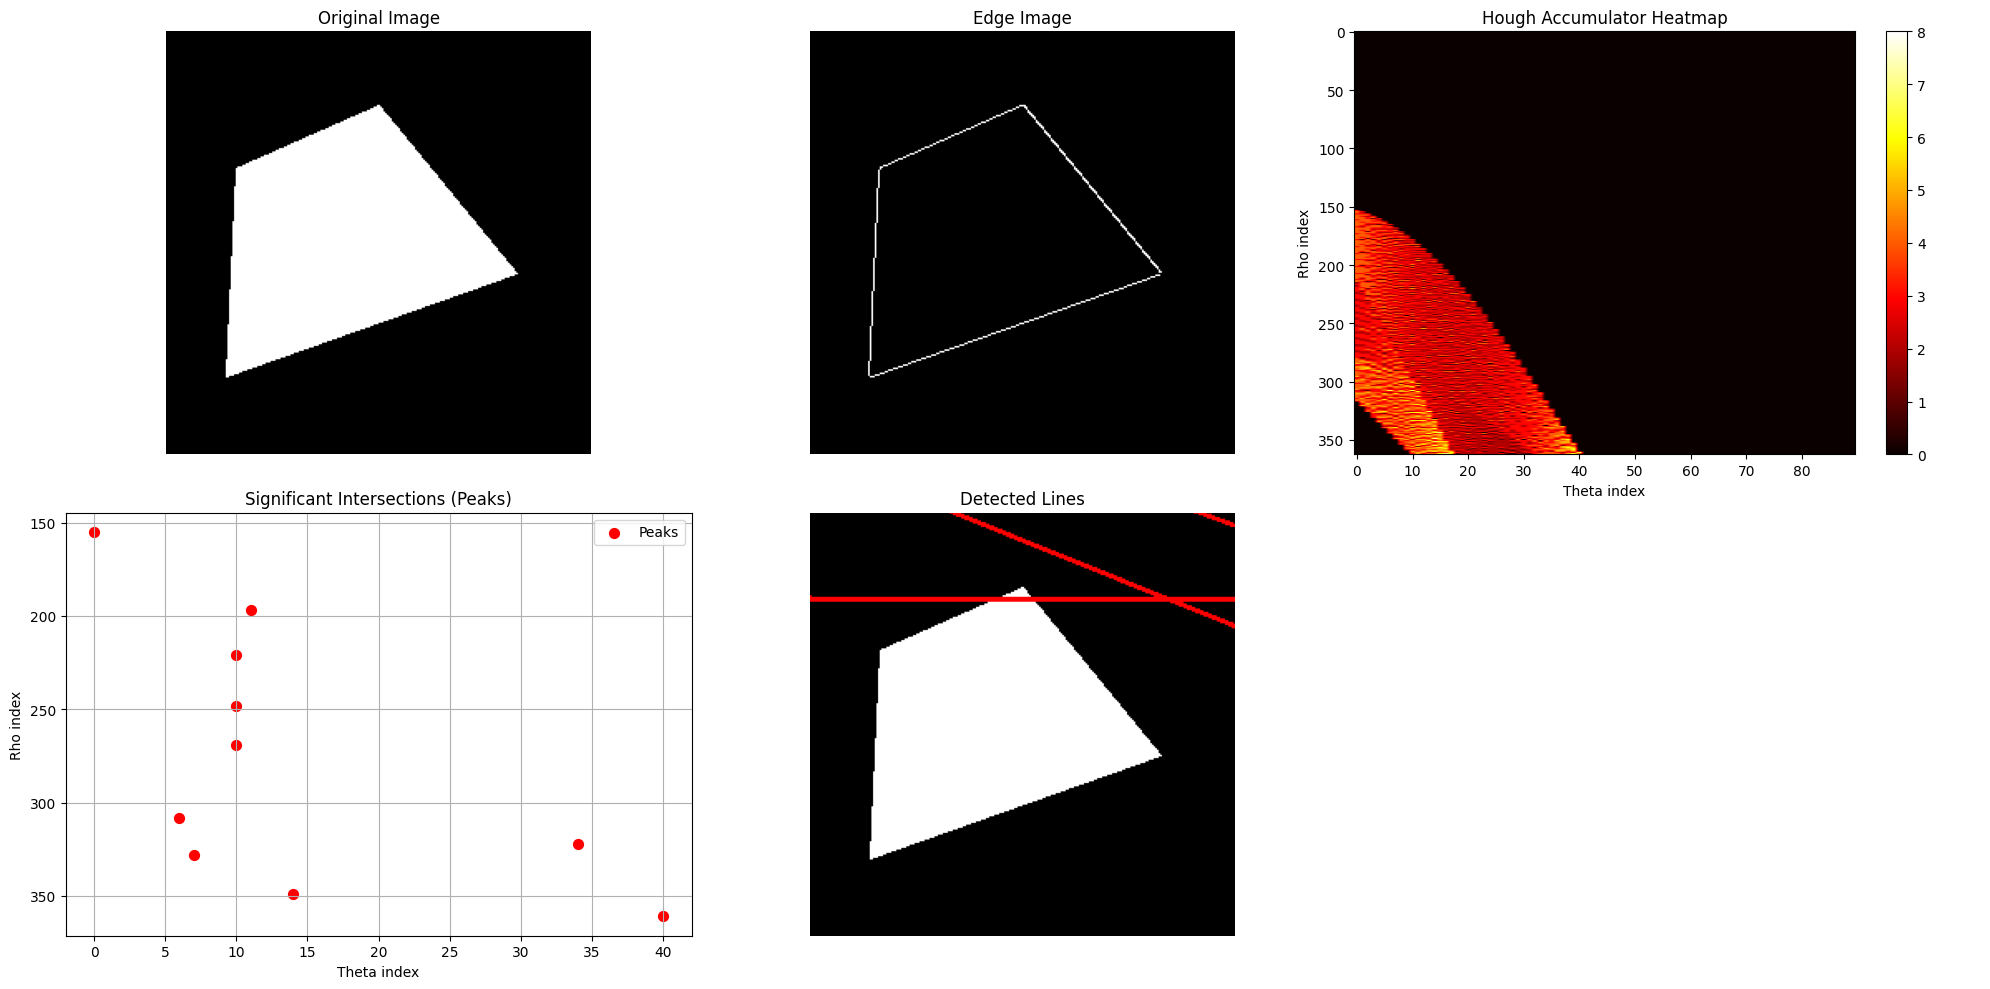


Processing test.bmp with coarse quantization (theta_res=5, rho_res=5)
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
  Peak at rho_idx=0, theta_idx=0, votes=0
Total peaks found: 20


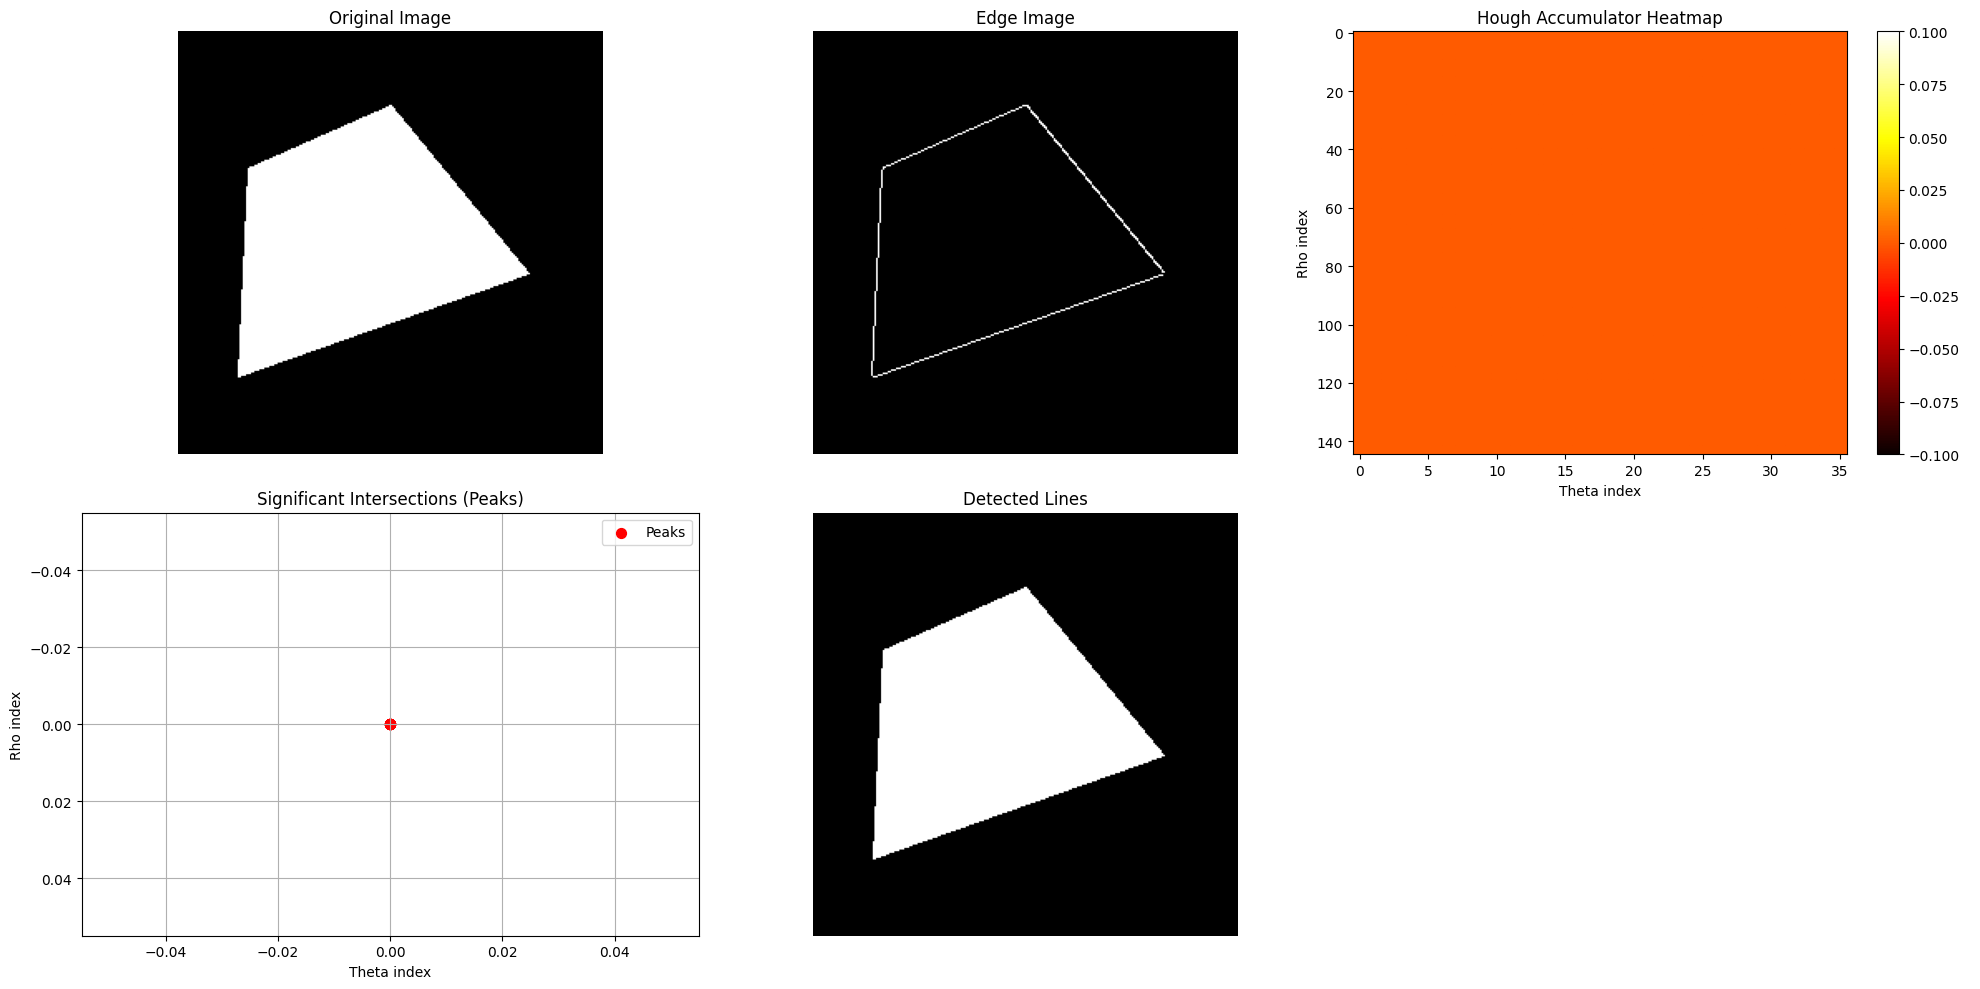

In [8]:
#testing on images
images = ['test2.bmp', 'input.bmp', 'test.bmp']
for img_name in images:
    print(f"\nProcessing {img_name} with fine quantization (theta_res=1, rho_res=1)")
    proc_image(img_name, theta_res=1, rho_res=1, num_peaks=10, threshold=0.5)

    print(f"\nProcessing {img_name} with fine quantization (theta_res=1, rho_res=1)")
    proc_image(img_name, theta_res=2, rho_res=2, num_peaks=10, threshold=0.5)

    print(f"\nProcessing {img_name} with coarse quantization (theta_res=5, rho_res=5)")
    proc_image(img_name, theta_res=5, rho_res=5, num_peaks=20, threshold=0.1)